In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def get_sp_stats_df(df):
    # Get regime stats
    # df - adj close price data
    df['ret'] = df['Adj Close'].pct_change()

    df['ret'][0] = 0

    df['cumret'] = (1 + df['ret']).cumprod()

    periods = []

    regime = 0

    peak = (1,0)
    trough = (1,0)

    for i in range(len(df)):

        if regime==0:

            cum_ret = df.iloc[i,-1]
            
            if cum_ret<0.81:
                regime = -1
                trough = (cum_ret,i)

            elif cum_ret>1.24:
                regime = 1
                peak = (cum_ret,i)

        else:

            if regime == -1:
                if df.iloc[i,-1]/trough[0]>1.24:
                    regime = 1
                    periods.append({'regime':'bear','top/bottom':df.index[trough[1]],'index':df.iloc[trough[1],0],'% move':(trough[0]/peak[0])-1,'mean':np.mean(df.iloc[peak[1]:trough[1],1]),'stddev':np.std(df.iloc[peak[1]:trough[1],1]),'duration':trough[1]-peak[1]})
                    peak = (df.iloc[i,-1],i)

                elif df.iloc[i,-1] < trough[0]:
                    trough = (df.iloc[i,-1],i)

            elif regime == 1:       
                if df.iloc[i,-1]/peak[0]<0.81:
                    regime = -1
                    periods.append({'regime':'bull','top/bottom':df.index[peak[1]],'index':df.iloc[peak[1],0],'% move':(peak[0]/trough[0])-1,'mean':np.mean(df.iloc[trough[1]:peak[1],1]),'stddev':np.std(df.iloc[trough[1]:peak[1],1]),'duration':peak[1]-trough[1]})
                    trough = (df.iloc[i,-1],i)

                elif df.iloc[i,-1] > peak[0]:
                    peak = (df.iloc[i,-1],i)

    if regime == -1:
        periods.append({'regime':'bear','top/bottom':df.index[trough[1]],'index':df.iloc[trough[1],0],'% move':(trough[0]/peak[0])-1,'mean':np.mean(df.iloc[peak[1]:trough[1],1]),'stddev':np.std(df.iloc[peak[1]:trough[1],1]),'duration':len(df)-peak[1]})

    elif regime == 1:       
        periods.append({'regime':'bull','top/bottom':df.index[peak[1]],'index':df.iloc[peak[1],0],'% move':(peak[0]/trough[0])-1,'mean':np.mean(df.iloc[trough[1]:peak[1],1]),'stddev':np.std(df.iloc[trough[1]:peak[1],1]),'duration':len(df)-trough[1]})


    stats_df = pd.DataFrame.from_dict(periods)
    stats_df.index = pd.to_datetime(stats_df['top/bottom'])
    stats_df.drop(['top/bottom'],axis=1,inplace=True)
    # stats_df.to_excel('params.xlsx')

    return stats_df

def calculate_params_v4(data, rho_df, df):
    # compute params based on regime
    # df - stats_df

    uptrend_lengths = []
    downtrend_lengths = []

    uptrend_ann_rets = []
    downtrend_ann_rets = []

    sigma1 = []
    sigma2 = []

    for i in range(len(df)):
        
        if df['regime'][i] == 'bull':
            uptrend_lengths.append(252/df['duration'][i])
            # uptrend_ann_rets.append((1 + df['% move'][i])**(252/df['duration'][i]) - 1)
            uptrend_ann_rets.append(df['mean'][i] * 252)
            sigma1.append(df['stddev'][i] * (252**0.5))
        
        elif df['regime'][i] == 'bear':
            downtrend_lengths.append(252/df['duration'][i])
            # downtrend_ann_rets.append((1 + df['% move'][i])**(252/df['duration'][i]) - 1)  
            downtrend_ann_rets.append(df['mean'][i] * 252)      
            sigma2.append(df['stddev'][i] * (252**0.5))

    lambda1 = np.mean(uptrend_lengths)
    lambda2 = np.mean(downtrend_lengths)

    mu1 = np.mean(uptrend_ann_rets)
    mu2 = np.mean(downtrend_ann_rets)

    # print(data)

    sigma = np.mean(sigma1)/2 + np.mean(sigma2)/2

    # sigma  = np.std(data['ret']) * np.sqrt(252)

    rho = np.median(rho_df)

    params = {'lambda1':lambda1,'lambda2':lambda2,'mu1':mu1,'mu2':mu2,'sigma':sigma,'K':0.001,'rho':rho/100}

    for k in params.keys():
        if np.isnan(params[k]):
            params[k] = 0

    return params 

In [8]:
from HJB_Solver import get_thresholds

def p_t1(pt,params,S0,S1):

    dt = 1/252

    g_pt = -pt*(params['lambda1']+params['lambda2']) + params['lambda2'] - (pt*(params['mu1']-params['mu2'])*(1-pt)*(pt*(params['mu1']-params['mu2']) +params['mu2'] - 0.5*(params['sigma']**2)))/(params['sigma']**2)

    return min(max(pt + g_pt*dt + (pt * (1-pt) * (params['mu1']-params['mu2']) * np.log(S1/S0))/(params['sigma']**2),0),1)



def backtest_v4(data,params,p_i,position,last,last_buy,bal,bh_bal,cum_ret):
    # this is for one year

    # data = yf.download("^GSPC", start=start_date, end=end_date).loc[:,['Adj Close']]
    # data.index = pd.to_datetime(data.index)

    old_bal = bal
    old_bh_bal = bh_bal
    
    data = data.loc[:,['Adj Close','ret']]

    if position == 0:
        last_sell = 0

    # print(data)

    # p_s = 0.8
    # p_b = 0.95
    p_b, p_s = get_thresholds(params)

    if p_i == None:
        data['P(t)'] = pd.Series([(p_b + p_s)/2]*len(data),index=data.index)
    else:
        data['P(t)'] = pd.Series([p_i]*len(data),index=data.index)

    data['position'] = pd.Series([position]*len(data),index=data.index)

    # data['ret'] = data['Adj Close'].pct_change()

    data = data.loc[:,['Adj Close','P(t)','position','ret']]

    # data['ret'][0] = 0

    # for i in range(1,len(data)):

    #     # pt1 = p_t1(data.iloc[i-1,1],params,data.iloc[i-1,0],data.iloc[i,0])
    #     pt1 = p_t1(data['P(t)'][i-1],params,data['Adj Close'][i-1],data['Adj Close'][i])

    #     # data.iloc[i,1] = pt1
    #     data['P(t)'][i] = pt1

    #     # if data.iloc[i-1,2]==0 and pt1>=p_b:
    #     if data['position'][i-1]==0 and pt1>=p_b:
    #         # data.iloc[i,2] = 1
    #         data['position'][i] = 1
    #     # elif data.iloc[i-1,2]==1 and pt1<=p_s:
    #     elif data['position'][i-1]==1 and pt1<=p_s:
    #         # data.iloc[i,2] = 0
    #         data['position'][i] = 0
    #     else:
    #         # data.iloc[i,2] = data.iloc[i-1,2]
    #         data['position'][i] = data['position'][i-1]

    for i in range(1,len(data)):

        pt1 = p_t1(data.iloc[i-1,1],params,data.iloc[i-1,0],data.iloc[i,0])

        data.iloc[i,1] = pt1

        if data.iloc[i-1,2]==0 and pt1>=p_b:
            data.iloc[i,2] = 1
        elif data.iloc[i-1,2]==1 and pt1<=p_s:
            data.iloc[i,2] = 0
        else:
            data.iloc[i,2] = data.iloc[i-1,2]

    data['strat_ret'] = data['position'].shift(1) * data['ret']

    rho = (1+params['rho'])**(1/252) - 1

    data['strat_ret'][data['position'].shift(1)==0] = rho

    if position==0:
        data['strat_ret'][0] = rho
    else:
        data['strat_ret'][0] = data['ret'][0]

    # print(data)

    # bal = 1
    # last_buy = 0
    rets = []

    count = 0

    for i in range(1,len(data)):

        # if data.iloc[i-1,2]==0 and data.iloc[i,2]==1:
        if data['position'][i-1]==0 and data['position'][i]==1:

            bal*= (1+params['rho'])**((i - last_sell)/252)

            # last_buy = data.iloc[i,0]
            last_buy = data['Adj Close'][i]


        elif data['position'][i-1]==1 and data['position'][i]==0 and last_buy!=0:

            # bal *= data.iloc[i,0]/last_buy
            bal *= data['Adj Close'][i]/last_buy

            last_sell = i
            # print(last_buy)
            # rets.append(data.iloc[i,0]/last_buy - 1)
            rets.append(data['Adj Close'][i]/last_buy - 1)
            count+=1
            last_buy = 0

    if last and last_buy!=0:
        # bal *= data.iloc[-1,0]/last_buy
        bal *= data['Adj Close'][-1]/last_buy
        count+=1
        last_buy = 0

    if data['position'][-1]==0:
        bal*= (1+params['rho'])**((len(data) - last_sell)/252)

    strat_ret = bal/old_bal - 1

    bh_bal*=data['Adj Close'][-1]/data['Adj Close'][0]
    # try:
    bh_ret = bh_bal/old_bh_bal - 1
    # except:
    #     print(start_date)
    #     print(end_date)
    #     print(data)

    data['cumret'] = (1+ data['strat_ret']).cumprod() * cum_ret

    
    plot_df = data.iloc[:,1:2]
    plot_df['p_b'] = pd.Series([p_b]*len(data),index=data.index)
    plot_df['p_s'] = pd.Series([p_s]*len(data),index=data.index)

    plot_df = plot_df[['p_b','p_s','P(t)']]

    return strat_ret, bh_ret, p_b, p_s, pt1, data.iloc[-1,2], last_buy, bal, bh_bal, count, plot_df, data.iloc[-1,-1], list(data['cumret'])


In [ ]:
# MAIN

import talib as ta
from ta.trend import MACD

def incr_date(date,n):
    return '-'.join([str(int(date.split('-')[0])+n)]+date.split('-')[1:])


df = yf.download("^GSPC", start="1960-01-01", end="2023-01-01").loc[:,['Adj Close']]
df.index = pd.to_datetime(df.index)

stats_df = get_sp_stats_df(df)

rho_df = yf.download("^TNX", start="1960-01-01", end="2023-01-01").loc[:,['Adj Close']]
rho_df.index = pd.to_datetime(rho_df.index)

pre_start_date = "1960-01-01"
in_start_date = incr_date(pre_start_date,3)
in_end_date = incr_date(in_start_date,10)

ma_sizes = (126,189,252,278,504,630,756)

ma_size_names = {126:'6-mo',189:'9-mo',252:'1-yr',278:'1.5-yr',504:'2-yr',630:'2.5-yr',756:'3-yr'}


for m_size in [504]:

    results2 = []

    dataset = df.copy()

    macd = MACD(dataset['Adj Close'],504,252,126)


    dataset['macd'] = macd.macd_diff()
    dataset['indicator'] = dataset.macd >= 0

    # dataset['ma'] = dataset['Adj Close'].rolling(m_size).mean()
    # dataset['change'] = np.sign(dataset['Adj Close']-dataset['ma'])
    dataset['ret'] = dataset['Adj Close'].pct_change()

    params_old = {}

    position = 0
    last_buy = 0
    last = False
    bal = 1
    bh_bal = 1
    plot_df = pd.DataFrame([],columns=['p_b','p_s','P(t)'])

    p_i = None

    count = 0

    cum_ret = 1

    cumrets_list = []

    for i in range(50):

        if i==49:
            last = True
 
        
        start_date = incr_date(in_start_date,i)
        end_date = incr_date(start_date,10)
        
        result = {'start-date':end_date,'end-date':incr_date(end_date,1),'ma_size':ma_size_names[m_size]}

        # stats_df = get_sp_stats_df(dataset[start_date:end_date])

        # params = calculate_params_v3(dataset[start_date:end_date],rho_df[start_date:end_date])
        params = calculate_params_v4(dataset[start_date:end_date],rho_df[start_date:end_date],stats_df[start_date:end_date])

        # break
        # print(params)
        # print(start_date,end_date)

        if params_old != {}:
            for k in list(params.keys())[:5]:

                # if np.isnan(params[k]):
                #     params[k] = params_old[k]
                #     continue

                if params[k]==0:
                    params[k] = params_old[k]
                    continue

                params[k] = (1-2/6) * params_old[k] + (2/6) * params[k]

        params_old = params

        # print(params)
        

        strat_ret, bh_ret, p_b, p_s, p_i, position, last_buy, bal, bh_bal, c, p_df, cum_ret, cumrets = backtest_v4(dataset[end_date:incr_date(end_date,1)],params,p_i,position,last,last_buy,bal,bh_bal,cum_ret)
        # strat_ret, bh_ret, p_b, p_s, p_i, position, last_buy, bal, bh_bal, c, p_df= backtest_v3(dataset[end_date:incr_date(end_date,1)],params,p_i,position,last,last_buy,bal,bh_bal)

        print(cum_ret)

        print(bal)

        # print(cum_ret/bal)

        print('\n\n')

        cumrets_list += cumrets

        plot_df = pd.concat([plot_df,p_df])

        # break

        count+=c

        result['strat_ret'] = strat_ret
        result['bh_ret'] = bh_ret
        result['p_b'] = p_b
        result['p_s'] = p_s

        for key in params.keys():
            result[key] = params[key]

        results2.append(result)

    results_df2 = pd.DataFrame(results2,columns=results2[0].keys()).round(3)

    # results_df2.to_excel('Results_v11.xlsx',sheet_name=ma_size_names[m_size])

    print(bal)

    print(bh_bal)

    print(count)

    print(count/50)

    
        

        



In [10]:
plot_df

,p_b,p_s,P(t)
1973-01-02,0.90875,0.71,0.809375
1973-01-03,0.90875,0.71,0.831624
1973-01-04,0.90875,0.71,0.822482
1973-01-05,0.90875,0.71,0.843264
1973-01-08,0.90875,0.71,0.840852
...,...,...,...
2022-12-23,0.89625,0.74,0.847459
2022-12-27,0.89625,0.74,0.834326
2022-12-28,0.89625,0.74,0.796736
2022-12-29,0.89625,0.74,0.858785


In [11]:
cumrets_list[-1]

13.51553290135375

In [12]:
data = yf.download("^GSPC", start="1960-01-01", end="2023-01-01").loc[:,['Adj Close']]
data.index = pd.to_datetime(data.index)
data

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
1960-01-04,59.910000
1960-01-05,60.389999
1960-01-06,60.130001
1960-01-07,59.689999
1960-01-08,59.500000
...,...
2022-12-23,3844.820068
2022-12-27,3829.250000
2022-12-28,3783.219971


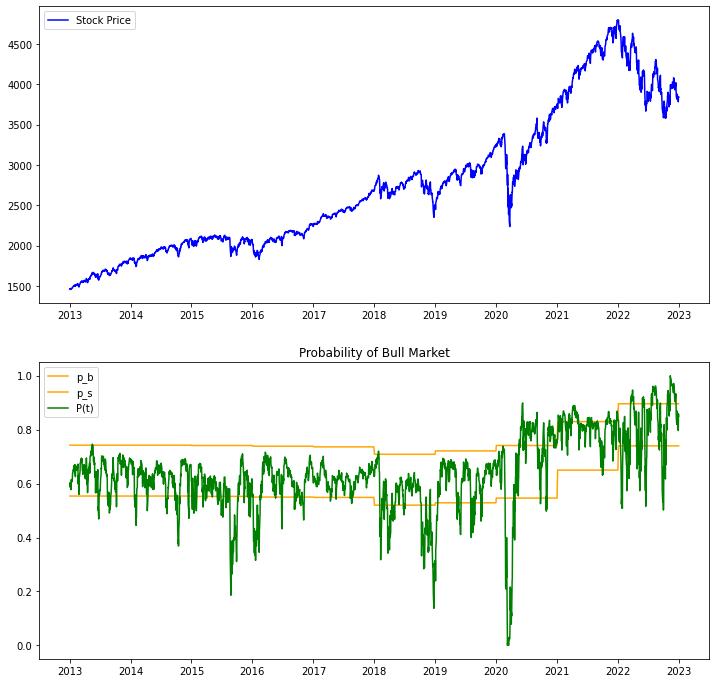

In [13]:
# plot_df['1993-01-01':'2003-01-01'].plot()

data3 = data['2013-01-01':'2023-01-01']
plot_df2 = plot_df['2013-01-01':'2023-01-01']

_, (ax1,ax2) = plt.subplots(2,1,figsize=(12,12))

ax1.plot(data3['Adj Close'],color='blue')
ax1.legend(['Stock Price'])

ax2.plot(plot_df2['p_b'],color='orange')
ax2.plot(plot_df2['p_s'],color='orange')
ax2.plot(plot_df2['P(t)'],color='green')
ax2.legend(['p_b','p_s','P(t)'])
ax2.set_title('Probability of Bull Market')

plt.show()

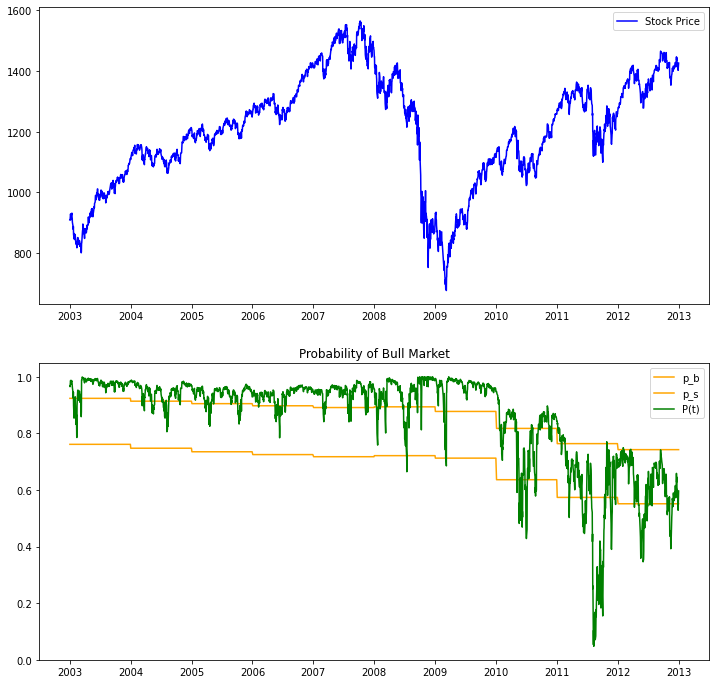

In [14]:
# plot_df['1993-01-01':'2003-01-01'].plot()

data3 = data['2003-01-01':'2013-01-01']
plot_df2 = plot_df['2003-01-01':'2013-01-01']

_, (ax1,ax2) = plt.subplots(2,1,figsize=(12,12))

ax1.plot(data3['Adj Close'],color='blue')
ax1.legend(['Stock Price'])

ax2.plot(plot_df2['p_b'],color='orange')
ax2.plot(plot_df2['p_s'],color='orange')
ax2.plot(plot_df2['P(t)'],color='green')
ax2.legend(['p_b','p_s','P(t)'])
ax2.set_title('Probability of Bull Market')

plt.show()

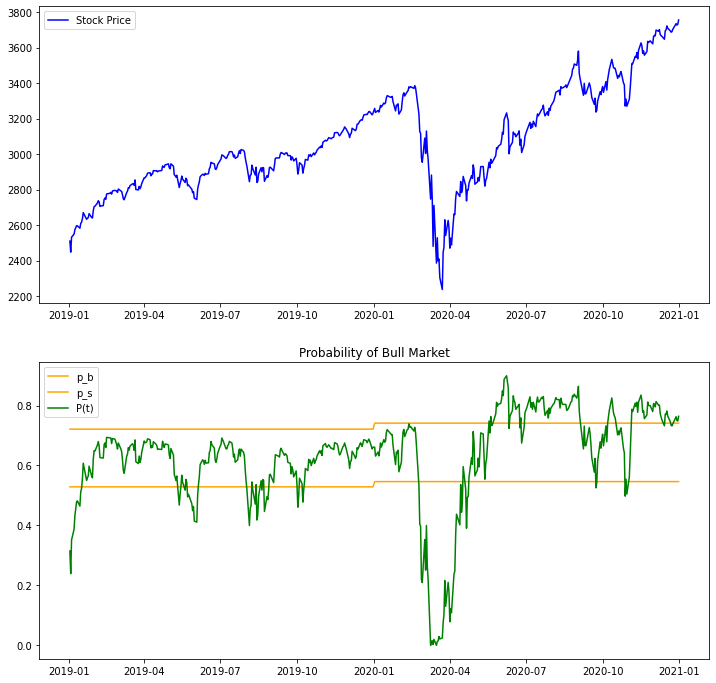

In [15]:
# plot_df['1993-01-01':'2003-01-01'].plot()

data3 = data['2019-01-01':'2021-01-01']
plot_df2 = plot_df['2019-01-01':'2021-01-01']

_, (ax1,ax2) = plt.subplots(2,1,figsize=(12,12))

ax1.plot(data3['Adj Close'],color='blue')
ax1.legend(['Stock Price'])

ax2.plot(plot_df2['p_b'],color='orange')
ax2.plot(plot_df2['p_s'],color='orange')
ax2.plot(plot_df2['P(t)'],color='green')
ax2.legend(['p_b','p_s','P(t)'])
ax2.set_title('Probability of Bull Market')

plt.show()

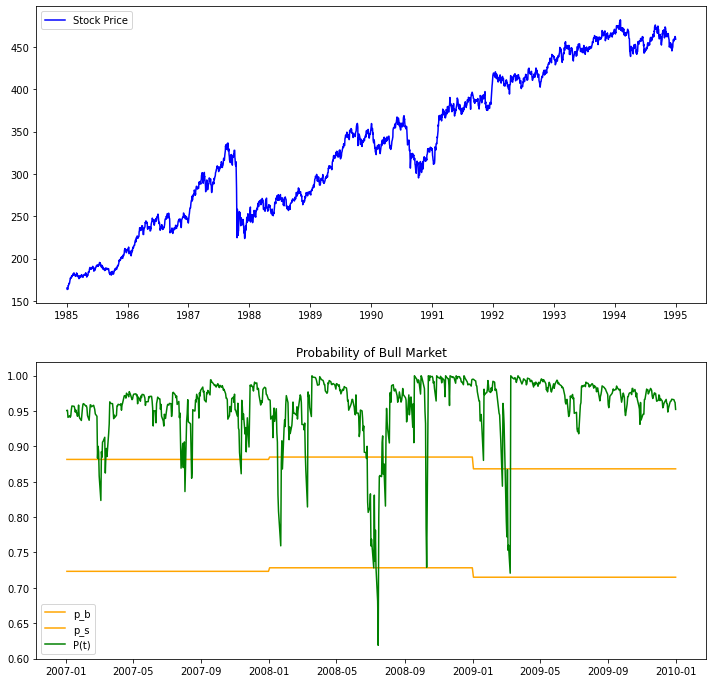

In [68]:
# plot_df['1993-01-01':'2003-01-01'].plot()

data3 = data['1985-01-01':'1995-01-01']
plot_df2 = plot_df['2007-01-01':'2010-01-01']

_, (ax1,ax2) = plt.subplots(2,1,figsize=(12,12))

ax1.plot(data3['Adj Close'],color='blue')
ax1.legend(['Stock Price'])

ax2.plot(plot_df2['p_b'],color='orange')
ax2.plot(plot_df2['p_s'],color='orange')
ax2.plot(plot_df2['P(t)'],color='green')
ax2.legend(['p_b','p_s','P(t)'])
ax2.set_title('Probability of Bull Market')

plt.show()

In [69]:
cum_strat_rets = [1]

for x in list(results_df2.iloc[:,3]):

    cum_strat_rets.append(cum_strat_rets[-1] * (1+x))

In [70]:
cum_bh_rets = [1]

for x in list(results_df2.iloc[:,4]):

    cum_bh_rets.append(cum_bh_rets[-1] * (1+x))

In [71]:
cum_ret_df = pd.DataFrame(cum_strat_rets[1:],index=results_df2['end-date'],columns=['Strat_CumRet'])

cum_ret_df['BH_CumRet'] = pd.Series(cum_bh_rets[1:],index=results_df2['end-date'])

cum_ret_df.index = pd.to_datetime(cum_ret_df.index)

cum_ret_df

,Strat_CumRet,BH_CumRet
end-date,,
1974-01-01,1.005000,0.819000
1975-01-01,0.940680,0.574938
1976-01-01,1.231350,0.738220
1977-01-01,1.386500,0.872577
1978-01-01,1.422549,0.775721
1979-01-01,1.523550,0.794338
1980-01-01,1.429090,0.886481
1981-01-01,1.386217,1.138242
1982-01-01,1.571971,1.023279


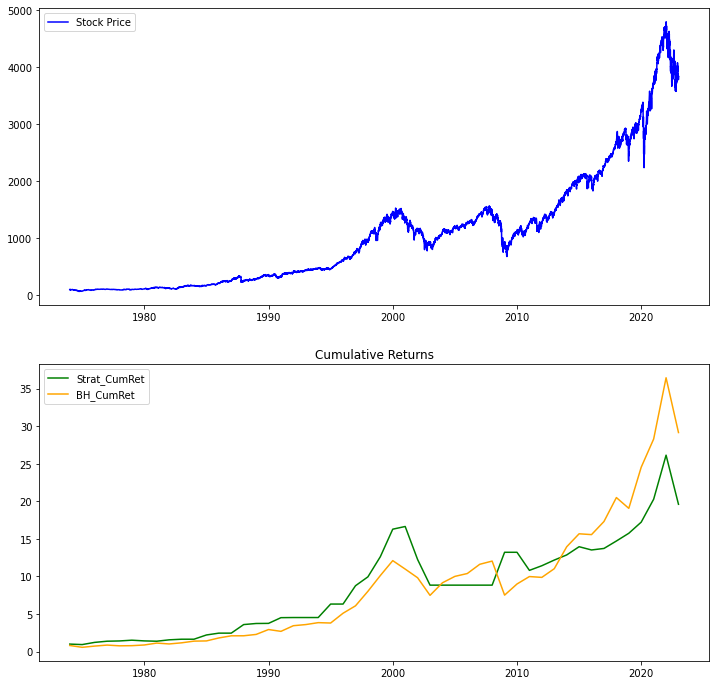

In [72]:
_, (ax1,ax2) = plt.subplots(2,1,figsize=(12,12))

ax1.plot(data['Adj Close']['1974-01-01':],color='blue')
ax1.legend(['Stock Price'])

ax2.plot(cum_ret_df['Strat_CumRet'],color='green')
ax2.plot(cum_ret_df['BH_CumRet'],color='orange')
ax2.legend(['Strat_CumRet','BH_CumRet'])
ax2.set_title('Cumulative Returns')

plt.show()

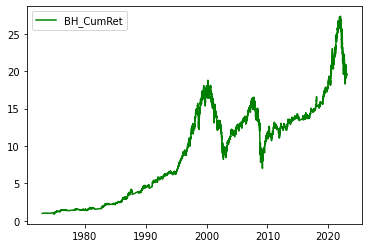

In [73]:
# plt.plot(data['Adj Close']['1973-01-01':],color='blue')

cum_ret_df = pd.DataFrame(cumrets_list,index=data['Adj Close']['1973-01-01':].index,columns=['Strat_CumRet'])

plt.plot(cum_ret_df['Strat_CumRet'],color='green')
# ax2.plot(cum_ret_df['BH_CumRet'],color='orange')
plt.legend(['BH_CumRet','Strat_CumRet'])
# plt.set_title('Cumulative Returns')

plt.show()

In [74]:
cumrets_list

[1.000211733426953,
 1.0004235116849498,
 1.000635334783483,
 1.000847202732047,
 1.0010591155401376,
 1.0012710732172534,
 1.0014830757728945,
 1.0016951232165632,
 1.0019072155577637,
 1.0021193528060026,
 1.002331534970788,
 1.0025437620616302,
 1.0027560340880417,
 1.0029683510595369,
 1.003180712985632,
 1.0033931198758455,
 1.0036055717396977,
 1.003818068586711,
 1.0040306104264103,
 1.0042431972683215,
 1.0044558291219732,
 1.004668505996896,
 1.0048812279026225,
 1.005093994848687,
 1.005306806844626,
 1.0055196638999784,
 1.0057325660242844,
 1.005945513227087,
 1.0061585055179303,
 1.0063715429063613,
 1.0065846254019288,
 1.0067977530141834,
 1.0070109257526776,
 1.0072241436269662,
 1.007437406646606,
 1.007650714821156,
 1.0078640681601767,
 1.008077466673231,
 1.0082909103698838,
 1.0085043992597018,
 1.0087179333522542,
 1.0089315126571117,
 1.0091451371838474,
 1.009358806942036,
 1.009572521941255,
 1.0097862821910832,
 1.0100000877011015,
 1.0102139384808932,
 1.0104

In [75]:
data = data['1973-01-01':]
data['ret'] = data['Adj Close'].pct_change()
data['ret'][0] = 0
data['cumret'] = (1+data['ret']).cumprod()
data['strat_ret'] = pd.Series(cumrets_list,index=data.index)
data

,Adj Close,ret,cumret,strat_ret
Date,,,,
1973-01-02,119.099998,0.000000,1.000000,1.000212
1973-01-03,119.570000,0.003946,1.003946,1.000424
1973-01-04,119.400002,-0.001422,1.002519,1.000635
1973-01-05,119.870003,0.003936,1.006465,1.000847
1973-01-08,119.849998,-0.000167,1.006297,1.001059
...,...,...,...,...
2022-12-23,3844.820068,0.005868,32.282285,19.656921
2022-12-27,3829.250000,-0.004050,32.151554,19.577318
2022-12-28,3783.219971,-0.012021,31.765072,19.341986


<AxesSubplot:xlabel='Date'>

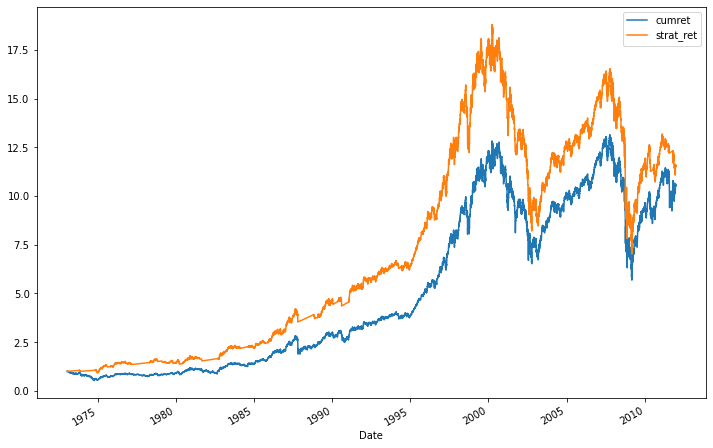

In [76]:
data[:'2012-01-01'][['cumret','strat_ret']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

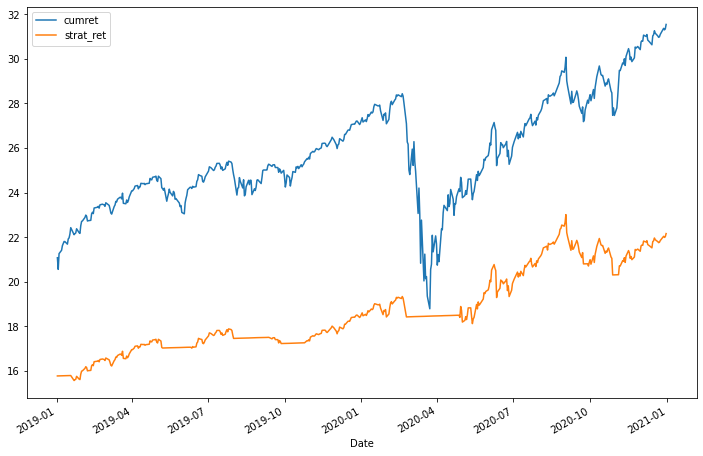

In [77]:
data['2019-01-01':'2021-01-01'][['cumret','strat_ret']].plot(figsize=(12,8))

In [ ]:
data.iloc[-1,-1] ** (1/50) - 1

0.0692627000405317

In [ ]:
data.iloc[-1,-2] ** (1/50) - 1

0.0719320552083369